In [1]:
#Define imports
from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
import sys
sys.path.insert(0, '/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src')
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings
from scipy.stats import sem
import xarray as xr




# Figures 3 & 4

### Here we process all the profiles, saving out the individual fitting information, so that we can inspect the fits, and also each step in the data processing procedure

21
nb 3
nu 5.785714285714286
cl 0.4101042565416542
cu 5.04843985776671
(3, 120)


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/3270717478.py:411: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/3270717478.py:411: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


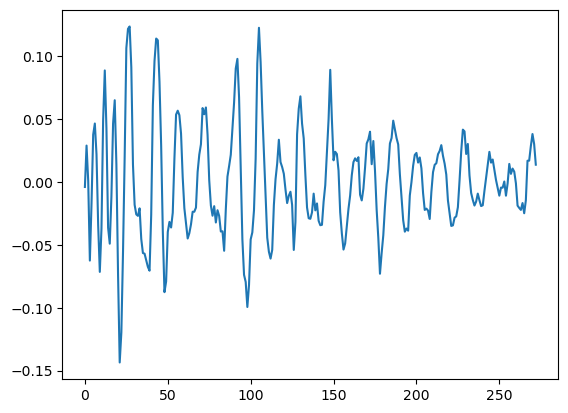

In [18]:
"""
Script to process all the LCDRI data, generate 1D surface wave spectra, and calculate significant wave heights

"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings
from scipy.stats import sem



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 25
navg = 50
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2
###########################


nblock = 120
fs = 1
overlap = 60

### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_loc_store = []
big_prof_speed_store = []
big_rotf_store = []
resid_store = np.array([])
errors_store = np.array([])
se_store = np.array([])
var_store = np.array([])



#For investigating down profiles
#down_min_z = []
#up_min_z =[]

up_count = 0
down_count = 0
up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , (nblock//2)-1))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    prof_speed_store = np.zeros(len(efr_files))
    rotf_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 3))
    loc_store = np.zeros((len(efr_files), 2))
    v_std_store = np.zeros(len(efr_files))
    u_std_store = np.zeros(len(efr_files))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)
        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef = Pef[moving_inds]
        
        #[HX, HY] = correct_magnetometer(HX, HY)
        
        a,b = signal.butter(10, 0.04, 'hp', fs=1, analog=False)
        E1_filtered = signal.filtfilt(a, b, E1)
        E2_filtered = signal.filtfilt(a, b, E2)
        
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        
        #Try a 50s fit on the filtered data
        [e1offs_f,e2offs_f,e1fits_f,e2fits_f,anghxhy_f, resid_f] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1_filtered,E2_filtered,HX,HY);


        #Try ignoring a portion of the windows
        for window in range(len(e1fits[0, :])):
            if window==0:
                #e1fits[np.where(~np.isnan(e1fits[:, window]))[0][:11], window]=np.nan
                e1fits[np.where(~np.isnan(e1fits[:, window]))[0][-2:], window] =np.nan
            
                #e2fits[np.where(~np.isnan(e2fits[:, window]))[0][:11], window]=np.nan
                e2fits[np.where(~np.isnan(e2fits[:, window]))[0][-2:], window] =np.nan
            else:
                e1fits[np.where(~np.isnan(e1fits[:, window]))[0][:3], window]=np.nan
                e1fits[np.where(~np.isnan(e1fits[:, window]))[0][-2:], window] =np.nan

                e2fits[np.where(~np.isnan(e2fits[:, window]))[0][:3], window]=np.nan
                e2fits[np.where(~np.isnan(e2fits[:, window]))[0][-2:], window] =np.nan
        
    
    
    
        #Get overall fit and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit
        
        
        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off_f=np.nanmean(e1offs_f,1);
            e2off_f=np.nanmean(e2offs_f,1);
            e1fit_f=np.nanmean(e1fits_f,1);
            e2fit_f=np.nanmean(e2fits_f,1);
            resid_f = np.nanmean(resid_f,1);

        #Calculate the residual
        e1r_f = E1_filtered - e1fit_f
        e2r_f = E2_filtered - e2fit_f
        
        

        E1tiled = np.tile(E1, (e1fits.shape[1], 1)).T
        E2tiled = np.tile(E2, (e1fits.shape[1], 1)).T
        
        e1r_mat = E1tiled - e1fits
        e2r_mat = E2tiled - e2fits

        #What if we apply a taper to e1r_mat?
        taper_in = np.linspace(1, 50, 50)*2*np.pi/50
        taper_in = taper_in - np.pi
        taper2 = np.cos(taper_in/2)*np.cos(taper_in/2)
        
        
        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            #print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        
        e1r_f = e1r_f*sfv1
        e2r_f = e2r_f*sfv2
        
        e1r_mat = e1r_mat*sfv1
        e2r_mat = e2r_mat*sfv2
        
        
        
        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        anghxhy[~np.isnan(anghxhy)] =  np.unwrap(avg_angs[~np.isnan(anghxhy)])
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        
        #avg_angs_f = np.copy(anghxhy_f)
        #anghxhy_f[~np.isnan(anghxhy_f)] =  np.unwrap(avg_angs_f[~np.isnan(anghxhy_f)])
        #avg_angs_f[~np.isnan(avg_angs_f)] = np.unwrap(avg_angs_f[~np.isnan(avg_angs_f)])


        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)
            #avg_angs_f = np.nanmean(avg_angs_f, axis=1)
            

        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs)
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs)
        
        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x_u = E_x
        E_y_u = E_y
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        #Do the same for the matrix
        E2_r_mat = e2r_mat*np.cos(anghxhy)+e1r_mat*np.sin(anghxhy)
        E1_r_mat = -e2r_mat*np.sin(anghxhy)+e1r_mat*np.cos(anghxhy)
        
        E_x_mat = E1_r_mat*np.cos(alpha1)-E2_r_mat*np.sin(alpha1)
        E_y_mat = E1_r_mat*np.sin(alpha1)+E2_r_mat*np.cos(alpha1)
        
        E_x_mat_filtered = signal.sosfilt(sos, E_x_mat)
        E_y_mat_filtered = signal.sosfilt(sos, E_y_mat)

        E_x_err = E_x_mat - np.tile(E_x_u, (E_x_mat.shape[1], 1)).T
        E_y_err = E_y_mat - np.tile(E_y_u, (E_y_mat.shape[1], 1)).T
        

        
        #Now take the spectra

        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        #If there's only one block worth of data, ignore the profile
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)

        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        

        if u_x.shape[0]==1:
            continue
        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        
            
        #Get the rotation frequency
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        rotf = rad_per_s/2/np.pi
        
        [rotf_reshaped, _] = reshape_u(rotf, Pef, nblock, overlap, fs)
        
        window_rotf = np.nanmean(rotf_reshaped, axis=1)
        
        
        zero_inds = np.where(prof_speed==0)[0]

            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)
        VVwindow, fwindow = make_vel_spectrum(u_y, fs)
        
        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            Eh = Exx+Eyy

                
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            
            u_noise = 0 #This is just for testing...
            [lbound, ubound, nu] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

            
            if ubound>5:
                print(prof_num)
                plt.plot(E_x)
                get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs, debug_flag=True)
                print(u_x.shape)

            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                prof_speed_store[counter] = np.nanmean(prof_speed)
                rotf_store[counter]=np.nanmean(window_rotf)
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                u_std_store[counter] = np.nanmean(np.nanstd(E_x_mat, axis=1))
                v_std_store[counter] = np.nanmean(np.nanstd(E_y_mat, axis=1))
                se_x = sem(E_x_mat, axis=1, nan_policy='omit')
                se_y = sem(E_y_mat, axis=1, nan_policy='omit')
                var_x = np.nansum(np.square(E_x_mat-np.tile(np.nanmean(E_x_mat, axis=1), (E_x_mat.shape[1], 1)).T), axis=1)/4
                var_y = np.nansum(np.square(E_y_mat-np.tile(np.nanmean(E_y_mat, axis=1), (E_x_mat.shape[1], 1)).T), axis=1)/4
                var_store = np.append(var_store, var_x)
                var_store = np.append(var_store, var_y)
                
                se_store = np.append(se_store, se_x)
                se_store = np.append(se_store, se_y)
                errors_store = np.append(errors_store, E_x_err.flatten())
                errors_store = np.append(errors_store, E_y_err.flatten())
                uncertainty_store[counter, :] = np.array([lbound, ubound, nu])
                loc_store[counter, :] = np.array([avg_lat, avg_lon])
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_loc_store = loc_store
        big_prof_speed_store = prof_speed_store
        big_rotf_store = rotf_store
        big_v_std_store = v_std_store
        big_u_std_store = u_std_store
        
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_prof_speed_store = np.append(big_prof_speed_store, prof_speed_store)
        big_rotf_store = np.append(big_rotf_store, rotf_store)
        big_loc_store = np.append(big_loc_store, loc_store, axis=0)
        big_u_std_store = np.append(big_u_std_store, u_std_store)
        big_v_std_store = np.append(big_v_std_store, v_std_store)
        

    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)

Text(257.5, 98.5, 'Rotation\n Period (13s)')

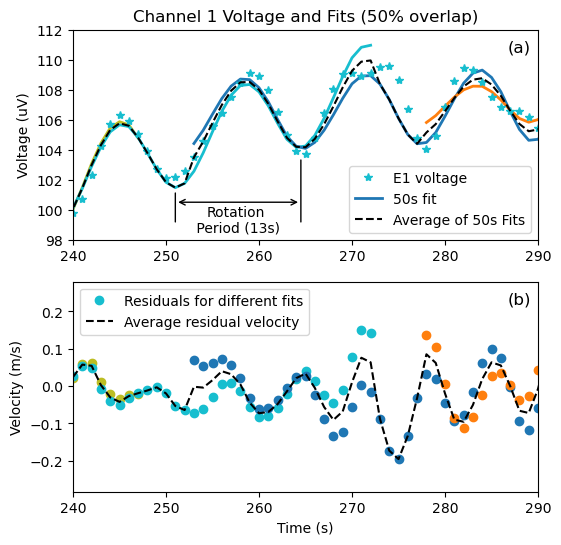

In [25]:
#plt.figure()
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.2)
gs.update(hspace=0.2)
plt.figure(figsize=(6,6))
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
#ax3 = plt.subplot(gs[:, 1])

#llim = 230
#ulim = 280
llim =240
ulim=290
#paxlt.subplot(212)
ax2.plot(e1r_mat, 'o') #label="Residuals for different fits")
ax2.plot(e1r_mat[:, 0], 'o', label="Residuals for different fits")
ax2.plot(e1r, 'k--', label="Average residual velocity")
#plt.plot(e1r_max, 'g-.')
ax2.set_xlim([llim, ulim])
ax2.set_ylabel("Velocity (m/s)")
#plt.title("Mean Velocity along channel 1 compared to velocity determined by each 50s fit")
ax2.legend()
ax2.set_xlabel("Time (s)")


ax1.plot(np.tile(E1, (29, 1)).T - e1r_mat/sfv1, linewidth=2)
ax1.plot(E1, '*', label="E1 voltage")
ax1.plot(E1 - e1r_mat[:, 0]/sfv1, label="50s fit", linewidth=2)
#plt.twinx()
ax1.plot(e1fit, 'k--', label="Average of 50s Fits")
ax1.set_xlim([llim, ulim])


#plt.plot(e1fit)
# plt.plot(np.tile(E1, (29, 1)).T - e1r_mat/sfv1)
# plt.plot(E1 - e1r_mat[:, 0]/sfv1, label="50s fit")


#plt.ylim([98, 111])
ax1.set_ylim([98, 112])
ax1.set_ylabel("Voltage (uV)")
ax1.set_title("Channel 1 Voltage and Fits (50% overlap)")
ax1.legend()

#Put letter labels
ax1.annotate(text='(a)', xy=(288, 110.5), fontsize=12, ha="center")
ax2.annotate(text='(b)', xy=(288, 0.22), fontsize=12, ha="center")
#ax3.annotate(text='(c)', xy=(-.067, 48.5), fontsize=12, ha="center")


#Lines for rotation period
ax1.annotate(text='', xy=(251,100.5), xytext=(264.5,100.5), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(text='', xy=(251,99), xytext=(251,101.3), arrowprops=dict(arrowstyle='-'))
ax1.annotate(text='', xy=(264.5,99), xytext=(264.5,103.5), arrowprops=dict(arrowstyle='-'))
ax1.annotate(text='Rotation\n Period (13s)', xy=(257.5,98.5), fontsize=10, ha="center")

#plt.savefig("/Users/jamesstadler/Documents/UW/TFOS/JTECH_Manuscript/proof_files/fitting_error_2panel.png")

#Save Fig 3 data

#np.savez(residuals = e1r_mat, mean_residual = e1r, voltage = E1, voltage_fits = np.tile(E1, (29, 1)).T - e1r_mat/sfv1, mean_voltage_fit = e1fit)

#Save errros data for use later
#np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/intermediate_processed_data/1hz_errors", errors=errors_store)

# Now Figure 4

In [20]:
#Load CDIP Data
from scipy.io import netcdf

fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
nc = netcdf.NetCDFFile(fname, 'r', mmap=False) 
cdip_time = nc.variables['waveTime'][:]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/3283662032.py:5: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  nc = netcdf.NetCDFFile(fname, 'r', mmap=False)


In [21]:



cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

#Get time
float_time = np.nanmean(mlt_efr)
cdip_ind = np.where(np.abs(cdip_time-float_time)==np.min(np.abs(cdip_time-float_time)))
[u_x, z_x] = reshape_u(E1_up, Pef_up, nblock, overlap, fs)
[u_y, z_y] = reshape_u(E2_up, Pef_up, nblock, overlap, fs)

[UUwindow, fwindow] = make_vel_spectrum(u_x, 1)
[VVwindow, fwindow] = make_vel_spectrum(u_y, 1)

UU = UUwindow/(int(120/2)*1)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(120/2)*1)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
Eh_pseudo_up = Exx+Eyy


[u_x, z_x] = reshape_u(E1_down, Pef, nblock, overlap, fs)
[u_y, z_y] = reshape_u(E2_down, Pef, nblock, overlap, fs)

[UUwindow, fwindow] = make_vel_spectrum(u_x, 1)
[VVwindow, fwindow] = make_vel_spectrum(u_y, 1)

UU = UUwindow/(int(120/2)*1)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(120/2)*1)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
Eh_pseudo_down = Exx+Eyy



In [22]:
#Calculate swift spectra


all_swift_file = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/testswiftnew.mat"

SWIFT_new = loadmat(all_swift_file)
swift_arr = np.array([[0,0,0,0,0,0,0]])
spec_array = np.array([])
for i in range(len(SWIFT_new['swift'][0, 0])):
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_temp = SWIFT_new['swift'][0, 0][i]
    #time = swift_temp[0, 0][0][0]
    #lon = swift_temp[0, 0][1][0]
    #lat = swift_temp[0, 0][2][0]
    #wavesigH = swift_temp[0, 0][9][0]
    mdtype = swift_temp.dtype
    ndata = {n: swift_temp[n] for n in mdtype.names}
    columns = [n for (n, v) in ndata.items()]
    df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
    lat=np.array(df['lat'][0], dtype=float).T
    lon=np.array(df['lon'][0], dtype=float).T
    time = np.array(df['time'][0], dtype=float).T
    hs = np.array(df['wavesigH'][0], dtype=float).T
    wave_dir = np.array(df['wavepeakdir'][0], dtype=float).T
    peak_T = np.array(df['wavepeakT'][0], dtype=float).T
    #lat_arr = np.expand_dims(lat, axis=1)
    #lon_arr = np.expand_dims(lon, axis=1)
    #time_arr = np.expand_dims(time, axis=1)
    #hs_arr = np.expand_dims(hs, axis=1)

    wave_spec = swift_temp['wavepower'][0, 0]
    #wave_spec[np.where(np.isnan(wave_spec))] = 0
    if len(spec_array) == 0:
        spec_array = wave_spec.T
    else:
        spec_array = np.vstack((spec_array, wave_spec.T))
    
    start_f = 0.03
    cutoff_freq = 0.5

    swift_freq = swift_temp['wavefreq'][0, 0][:, 0]
    end_f = np.where(swift_freq<cutoff_freq)[-1][-1]
    start_f = np.where(swift_freq>start_f)[0][0]
    spec_t = wave_spec[start_f:end_f].T
    swift_freq_t = swift_freq[start_f:end_f]
    #spec_t[np.where(np.isnan(spec_t))] = 0
    
    #swift_freq_t = np.tile(swift_freq_t
    #swift_freq_t = np.tile(swift_freq_t, (spec_t.shape[0], 1))
    Te_temp = np.array([])
    for spec_i in range(spec_t.shape[0]):
        Te_temp = np.append(Te_temp, np.trapz(spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])])/np.trapz(swift_freq_t[~np.isnan(spec_t[spec_i, :])]*spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])]))
    #Te_swift_store = np.append(Te_swift_store, Te_temp)
    Te_temp = np.expand_dims(Te_temp, (1))
    swift_temp_arr = np.hstack((time, lon, lat, hs, wave_dir, peak_T, Te_temp))
    swift_arr = np.vstack((swift_arr, swift_temp_arr))

    
swift_arr = np.delete(swift_arr, 0, 0)

#swift_arr2=swift_arr2[swift_arr[:, 0].argsort()]
spec_arr = spec_array[swift_arr[:, 0].argsort()]
swift_arr = swift_arr[swift_arr[:, 0].argsort()]
#spec_array = spec_array[swift_arr[:, 0].argsort()]

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/1457040233.py:40: RuntimeWarning: Mean of empty slice
  ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color, label="Up profile")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/1457040233.py:41: RuntimeWarning: Mean of empty slice
  ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color, label="Down profile")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_96618/1457040233.py:59: RuntimeWarning: Mean of empty slice
  mean_swift_spec = np.nanmean(spec_arr[blah, :], axis=0)


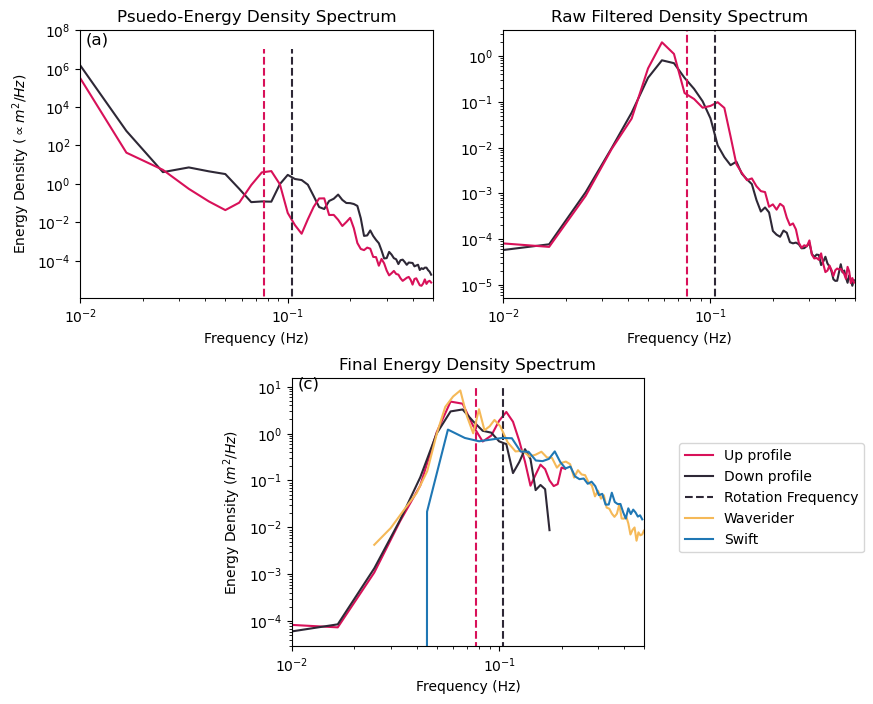

In [23]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
gs.update(hspace=0.3)
plt.figure(figsize=(10,8))
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
#plt.show()

ax1.loglog(fwindow[1:],np.nanmean(Eh_pseudo_down, axis=0), color=gray_color)
ax1.loglog(fwindow[1:],np.nanmean(Eh_pseudo_up, axis=0), color=red_color)
ax1.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10**7, color=gray_color, linestyle='--', label="Rotation Frequency")
ax1.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10**7, color=red_color, linestyle='--', label="Rotation Frequency")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"Energy Density ($\propto m^2/Hz$)")
ax1.set_title("Psuedo-Energy Density Spectrum")
ax1.set_xlim([0.01, 0.5])
ax1.annotate(text='(a)', xy=(0.012, 1.8*10**7), fontsize=12, ha="center")



ax2.loglog(fwindow[1:],np.nanmean(Eh_down, axis=0), color=gray_color)
ax2.loglog(fwindow[1:],np.nanmean(Eh_up, axis=0), color=red_color)


ax2.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10, color=red_color, linestyle='--', label="Rotation Frequency")
ax2.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10, color=gray_color, linestyle='--', label="Rotation Frequency")


ax2.set_xlabel("Frequency (Hz)")
#ax2.set_ylabel(r"Energy Density ($\propto m^2/Hz$)")
ax2.set_title("Raw Filtered Density Spectrum")
ax2.set_xlim([0.01, 0.5])
ax2.annotate(text='(b)', xy=(0.012, 9), fontsize=12, ha="center")




ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_up, axis=0), color=red_color, label="Up profile")
ax3.loglog(fwindow[1:],np.nanmean(Eh_corr_down, axis=0), color=gray_color, label="Down profile")


ax3.vlines(x=np.nanmean(rotf_up), ymin=0, ymax=10, color=red_color, linestyle='--')
ax3.vlines(x=np.nanmean(rotf_down), ymin=0, ymax=10, color=gray_color, linestyle='--', label="Rotation Frequency")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel(r"Energy Density ($m^2/Hz$)")
ax3.set_title("Final Energy Density Spectrum")
ax3.set_xlim([0.01, 0.5])
ax3.loglog(wave_freq, energy_density[cdip_ind[0], :].T, color=cdip_color, label="Waverider")


ax3.annotate(text='(c)', xy=(0.012, 9), fontsize=12, ha="center")

#Get swift shit
swift_dtime = datenum_to_datetime(swift_arr[:, 0])
apex_dtime = datetime.datetime.fromtimestamp(np.nanmean(mlt_efr))
blah = np.where(np.abs(apex_dtime-swift_dtime)<datetime.timedelta(hours=0.5))[0]
mean_swift_spec = np.nanmean(spec_arr[blah, :], axis=0)
#mean_swift_spec.shape
ax3.loglog(swift_freq, mean_swift_spec, label="Swift")


plt.legend(loc=(1.1,0.35))
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/spectral_flowchart.png")


In [17]:
#save fig 4 data
np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/PaperData/Attempt2/Fig4/fig4_data", apex_f = fwindow[1:], apex_raw_up = np.nanmean(Eh_pseudo_up, axis=0), apex_raw_down = np.nanmean(Eh_pseudo_up, axis=0), apex_filtered_up = np.nanmean(Eh_up, axis=0), apex_filtered_down = np.nanmean(Eh_down, axis=0), apex_corr_up = np.nanmean(Eh_corr_up, axis=0), apex_corr_down = np.nanmean(Eh_corr_down, axis=0), waverider_f = wave_freq, waverider_spec = energy_density[cdip_ind[0], :].T, swift_f = swift_freq, swift_spec = mean_swift_spec, rotf_down = np.nanmean(rotf_down), rotf_up = np.nanmean(rotf_up))  

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_2431/1977932445.py:2: RuntimeWarning: Mean of empty slice
  np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/PaperData/Attempt2/Fig4/fig4_data", apex_f = fwindow[1:], apex_raw_up = np.nanmean(Eh_pseudo_up, axis=0), apex_raw_down = np.nanmean(Eh_pseudo_up, axis=0), apex_filtered_up = np.nanmean(Eh_up, axis=0), apex_filtered_down = np.nanmean(Eh_down, axis=0), apex_corr_up = np.nanmean(Eh_corr_up, axis=0), apex_corr_down = np.nanmean(Eh_corr_down, axis=0), waverider_f = wave_freq, waverider_spec = energy_density[cdip_ind[0], :].T, swift_f = swift_freq, swift_spec = mean_swift_spec, rotf_down = np.nanmean(rotf_down), rotf_up = np.nanmean(rotf_up))
